In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# データの読み込み
# ここではCSVファイルから1分足データを読み込むと仮定します
# データには'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'の列が含まれているとします
data = pd.read_csv('../data/bybit_btcusdt_20210101-20230330.csv', parse_dates=['Timestamp'])
data.set_index('Timestamp', inplace=True)

In [5]:
# 移動平均線（SMA）
def SMA(series, period):
    return series.rolling(window=period).mean()

In [6]:
data['SMA_short'] = SMA(data['Close'], period=5)
data['SMA_long'] = SMA(data['Close'], period=20)

In [7]:
# ボリンジャーバンド
def Bollinger_Bands(series, period=20, std_multiplier=2):
    sma = series.rolling(window=period).mean()
    std = series.rolling(window=period).std()
    upper_band = sma + std_multiplier * std
    lower_band = sma - std_multiplier * std
    return upper_band, sma, lower_band

In [8]:
data['BB_upper'], data['BB_middle'], data['BB_lower'] = Bollinger_Bands(data['Close'], period=20, std_multiplier=2)


In [9]:
# RSIの計算
def RSI(series, period=14):
    delta = series.diff(1)
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    # 初期平均値
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    
    # 後続の平均値（指数移動平均を使用）
    avg_gain = avg_gain.combine_first(gain.ewm(alpha=1/period, min_periods=period).mean())
    avg_loss = avg_loss.combine_first(loss.ewm(alpha=1/period, min_periods=period).mean())
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [10]:
data['RSI'] = RSI(data['Close'], period=14)


In [11]:
# シグナルの生成
# 初期化
data['Signal'] = 0
data['Position'] = 0

In [12]:
for i in range(1, len(data)):
    # ロングエントリーの条件
    if (data['Close'].iloc[i] < data['BB_lower'].iloc[i]) and (data['RSI'].iloc[i] < 30) and \
       (data['SMA_short'].iloc[i] > data['SMA_long'].iloc[i]) and (data['SMA_short'].iloc[i-1] <= data['SMA_long'].iloc[i-1]):
        data['Signal'].iloc[i] = 1  # 買いシグナル

    # ショートエントリーの条件
    elif (data['Close'].iloc[i] > data['BB_upper'].iloc[i]) and (data['RSI'].iloc[i] > 70) and \
         (data['SMA_short'].iloc[i] < data['SMA_long'].iloc[i]) and (data['SMA_short'].iloc[i-1] >= data['SMA_long'].iloc[i-1]):
        data['Signal'].iloc[i] = -1  # 売りシグナル

    # ポジションの更新
    data['Position'].iloc[i] = data['Position'].iloc[i-1]

    # ポジションのエントリーとエグジット
    if data['Signal'].iloc[i] == 1:
        data['Position'].iloc[i] = 1  # ロングポジション
        entry_price = data['Close'].iloc[i]
    elif data['Signal'].iloc[i] == -1:
        data['Position'].iloc[i] = -1  # ショートポジション
        entry_price = data['Close'].iloc[i]
    else:
        # エグジット条件
        if data['Position'].iloc[i-1] == 1:
            # ロングポジションのエグジット条件
            if (data['Close'].iloc[i] >= data['SMA_long'].iloc[i]) or (data['Close'].iloc[i] <= entry_price * 0.99):
                data['Position'].iloc[i] = 0  # ポジション解消
        elif data['Position'].iloc[i-1] == -1:
            # ショートポジションのエグジット条件
            if (data['Close'].iloc[i] <= data['SMA_long'].iloc[i]) or (data['Close'].iloc[i] >= entry_price * 1.01):
                data['Position'].iloc[i] = 0  # ポジション解消


/tmp/ipykernel_355/1485058907.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = data['Position'].iloc[i-1]


In [13]:
# リターンの計算
data['Return'] = data['Close'].pct_change()
data['Strategy_Return'] = data['Return'] * data['Position'].shift(1)

# 累積リターンの計算
data['Cumulative_Market_Return'] = (1 + data['Return']).cumprod()
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

# パフォーマンスの評価
total_returns = data['Cumulative_Strategy_Return'].iloc[-1] - 1
annual_returns = data['Strategy_Return'].mean() * 252 * 24 * 60  # 年間リターン（1分足なので調整）
annual_std = data['Strategy_Return'].std() * np.sqrt(252 * 24 * 60)
sharpe_ratio = annual_returns / annual_std


/tmp/ipykernel_355/3643668583.py:13: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / annual_std


In [14]:
print(f"Total Strategy Returns: {total_returns * 100:.2f}%")
print(f"Annualized Returns: {annual_returns * 100:.2f}%")
print(f"Annualized Volatility: {annual_std * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Total Strategy Returns: 0.00%
Annualized Returns: 0.00%
Annualized Volatility: 0.00%
Sharpe Ratio: nan


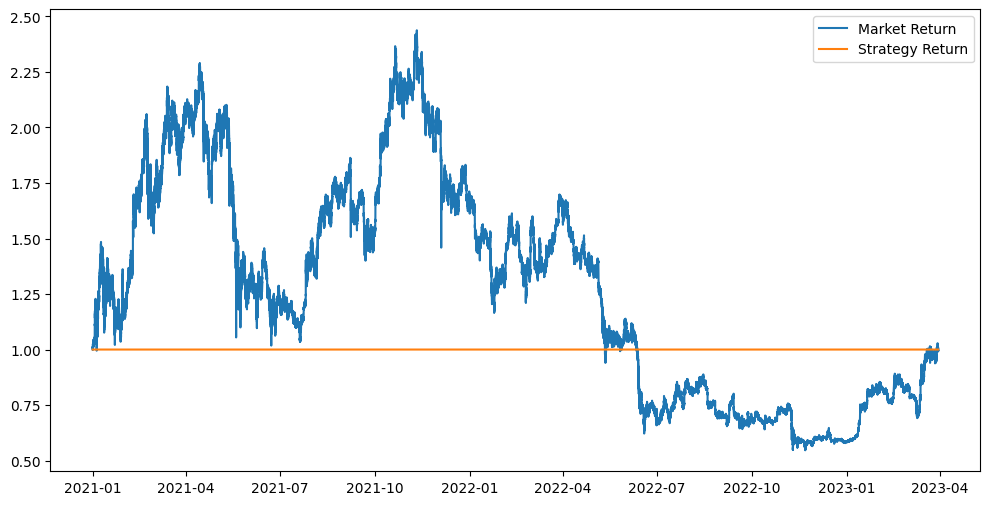

In [15]:
# 結果のプロット
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Market_Return'], label='Market Return')
plt.plot(data['Cumulative_Strategy_Return'], label='Strategy Return')
plt.legend()
plt.show()